In [124]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as m_a_e, mean_squared_error as m_s_e, r2_score as r2
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lime import lime_tabular

from scipy.stats.mstats import winsorize

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
dataset = "E:/Formation Data Scientist/Projet_4/2016_Building_Energy_Benchmarking.csv"

In [4]:
df = pd.read_csv(dataset)

### <a name='C2'> EDA et Choix des features   </a>

In [5]:
df.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [7]:
df.shape

(3376, 46)

- Exploration des valeurs nulles

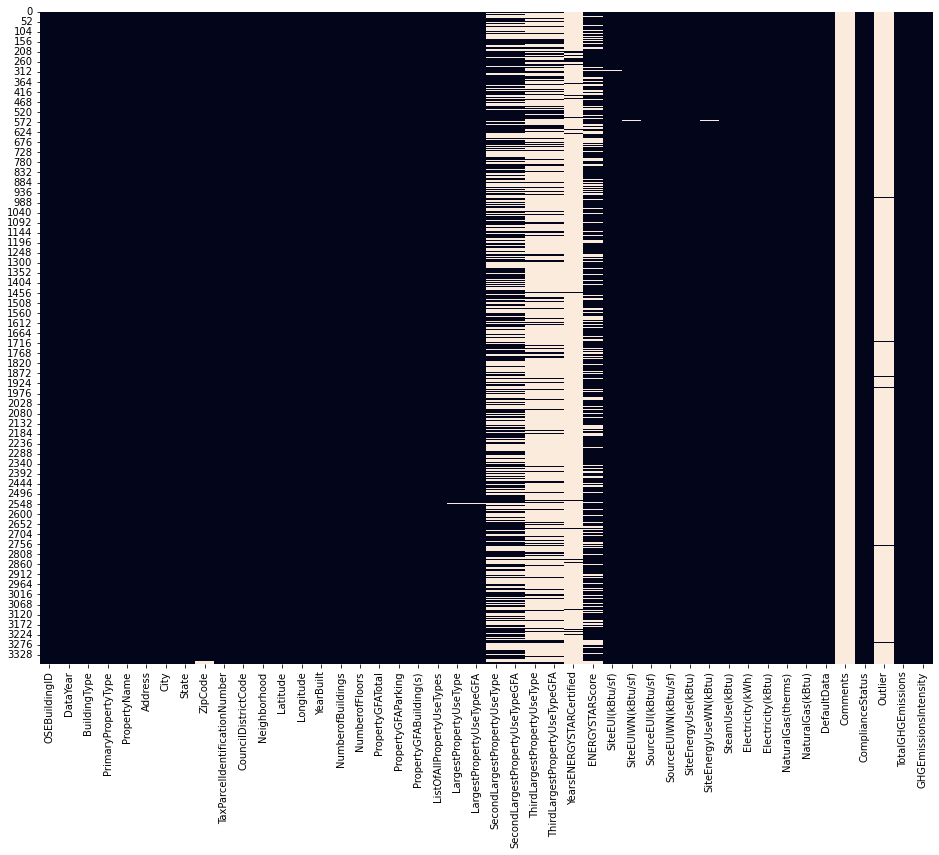

In [8]:
plt.figure(figsize=(16,12))
sns.heatmap(df.isna(),cbar=False)
plt.show()

- Typologie des variables

In [9]:
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

- Nombre de variables différentes par Feature

In [10]:
df.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [11]:
df['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [12]:
df['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

On a 8 types de buiding, seuls les buildings résidentiels nous interressent dans le cadre de notre étude

In [13]:
df.iloc[:,2].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

Ici ce sont les buildings de type Multifamily qui nous interressent (rajouter Campus??)

In [14]:
df.iloc[:,3].value_counts()

Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Residence Hall                  23
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

- Nombre de valeures nulles par feature

In [15]:
df.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697


In [16]:
building_type = ['NonResidential','NonResidential COS','NonResidential WA'] # Réflechir sur rajouter ou non Campus comme building résidentiel,'Campus','SPS-District K-12',

nonRes = df[df['BuildingType'].isin(building_type)].reset_index(drop=True)

- Nos deux targets sont **TotalGHGEmissions** et **SiteEnergyUse(kBtu)**

In [17]:
compliant = ['Compliant']

nonRes = nonRes[nonRes['ComplianceStatus'].isin(compliant)].reset_index(drop=True)

In [18]:
nonRes.shape

(1432, 46)

In [19]:
nonRes.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          181
Warehouse                      178
Large Office                   164
Mixed Use Property             101
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     40
Medical Office                  38
K-12 School                     38
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             1
Name: PrimaryPropertyType, dtype: int64

- Nettoyage et choix des features à utiliser

In [20]:
nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Low-Rise Multifamily'].index)

In [21]:
nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Residence Hall'].index)

In [22]:
nonRes.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          181
Warehouse                      178
Large Office                   164
Mixed Use Property             101
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     40
K-12 School                     38
Medical Office                  38
Self-Storage Facility           28
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [23]:
nonRes.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                               0
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseType        633
SecondLargestPropertyUseTypeGFA     633


In [24]:
nonRes['ComplianceStatus'].value_counts()

Compliant    1410
Name: ComplianceStatus, dtype: int64

In [25]:
nonRes['Outlier'].value_counts()

Series([], Name: Outlier, dtype: int64)

In [26]:
nonRes = nonRes[nonRes.Outlier.isnull()]

In [27]:
nonResidential = nonRes[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','SiteEnergyUse(kBtu)']]

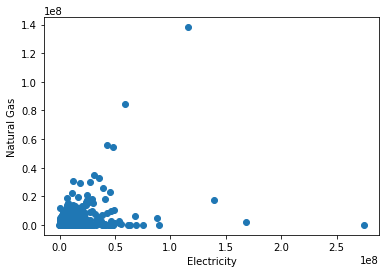

In [28]:
plt.scatter(nonResidential['Electricity(kBtu)'],nonResidential['NaturalGas(kBtu)'])
plt.xlabel('Electricity')
plt.ylabel('Natural Gas')
plt.show()

In [29]:
nonResidential.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    4
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
SiteEnergyUse(kBtu)          0
dtype: int64

In [30]:
nonResidential = nonResidential.dropna(axis=0) 

In [31]:
nonResidential['NumberofBuildings'].value_counts()

1.0    1329
0.0      44
2.0      11
3.0      10
6.0       4
5.0       3
4.0       2
9.0       1
7.0       1
8.0       1
Name: NumberofBuildings, dtype: int64

- Calcul de l'age des batiments

In [32]:
df1 = nonResidential.copy()

In [33]:
def fill_date(data):
    if data<= 1920:
        return "_1920"
    elif 1920<data<=1940:
        return "1920_1940"
    elif 1940<data<=1960:
        return "1940_1960"
    elif 1960<data<=1980:
        return "1960_1980"
    elif 1980<data<=2000:
        return "1980_2000"
    elif data>2000:
        return "2000_"

In [34]:
df1['YearBuilt'] = df1['YearBuilt'].apply(fill_date)

In [35]:
df1['SteamUse(kBtu)'] = df1['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['Electricity(kBtu)'] = df1['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['NaturalGas(kBtu)'] = df1['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [36]:
df2_code = pd.get_dummies(df1 ,columns=['PrimaryPropertyType','YearBuilt'])

In [37]:
train, test = train_test_split(df2_code, test_size=0.3, random_state=0) 

In [38]:
X_train, y1_train, X_test, y1_test = train.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]), train["TotalGHGEmissions"],test.drop(columns = ["TotalGHGEmissions",'SiteEnergyUse(kBtu)']) ,test["TotalGHGEmissions"]
X_train, y2_train, X_test, y2_test = train.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]), train["SiteEnergyUse(kBtu)"],test.drop(columns = ["TotalGHGEmissions",'SiteEnergyUse(kBtu)']) ,test["SiteEnergyUse(kBtu)"]

### <a name='C2'> Prédictions de TotalGHGEmissions   </a>

In [39]:
r_forest = RandomForestRegressor(random_state=0)

In [40]:
# entrainement du modèle
r_forest.fit(X_train, y1_train)

RandomForestRegressor(random_state=0)

In [41]:
# prédiction
preds = r_forest.predict(X_test)

# calcul du RMSE
print(m_s_e(y1_test,preds, squared=False))

225.28196282908175


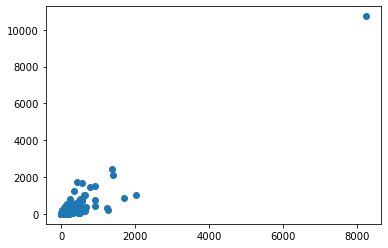

In [42]:
plt.scatter(preds,y1_test)

In [43]:
def get_error(n_estimator, X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=n_estimator, random_state=0)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [44]:
def get_dummy_error(strategy, X_train, X_test, y_train, y_test):
    model = DummyRegressor(strategy=strategy)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [45]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for strategy in ['mean', 'median']:
    my_rmse = get_dummy_error(strategy, X_train, X_test, y1_train, y1_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("strategy: %s  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(strategy, my_rmse[0], my_rmse[1], my_rmse[2]))

strategy: mean  		 RMSE:  580.784464  		 MAE: 186.041318  		 R2:  -0.000272
strategy: median  		 RMSE:  592.373010  		 MAE: 140.880142  		 R2:  -0.040587


In [46]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for n_estimator in [100, 200, 300, 400, 500]:
    my_rmse = get_error(n_estimator, X_train, X_test, y1_train, y1_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("N_Estimator: %d  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(n_estimator, my_rmse[0], my_rmse[1], my_rmse[2]))

N_Estimator: 100  		 RMSE:  225.281963  		 MAE: 93.918171  		 R2:  0.849498
N_Estimator: 200  		 RMSE:  247.327951  		 MAE: 96.410227  		 R2:  0.818601
N_Estimator: 300  		 RMSE:  246.105985  		 MAE: 96.628927  		 R2:  0.820389
N_Estimator: 400  		 RMSE:  250.427385  		 MAE: 96.689883  		 R2:  0.814026
N_Estimator: 500  		 RMSE:  252.698587  		 MAE: 97.167913  		 R2:  0.810638


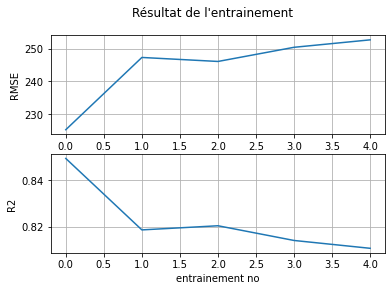

In [47]:
fig,(ax1,ax2) = plt.subplots(2,1)
fig.suptitle('Résultat de l\'entrainement')

ax1.plot(lst_rmse)
ax1.set_ylabel('RMSE')
ax1.set_xlabel('entrainement no')
ax1.grid()

ax2.plot(lst_r2)
ax2.set_ylabel('R2')
ax2.set_xlabel('entrainement no')
ax2.grid()

plt.show()

In [48]:
scores = []
best_scores = []

### - Dummy Regressor

In [49]:
dummy_param_grid = {'strategy' : ['mean','median']}

In [50]:
CV_dummy_mean = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_dummy_mean.fit(X_train, y1_train)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [51]:
CV_dummy_mean.best_score_

-0.0037899037977626284

In [52]:
dummy_model = CV_dummy_mean.best_estimator_

In [53]:
dummy_model.score(X_test,y1_test)

-0.0002718438953386304

In [54]:
print(f"Score - training data: {round(CV_dummy_mean.score(X_train,y1_train)*100,2)} %")
print(f"Score - test data: {round(CV_dummy_mean.score(X_test,y1_test)*100,2)} %")

Score - training data: 0.0 %
Score - test data: -0.03 %


In [55]:
scores.append(dummy_model.score(X_test,y1_test))
best_scores.append(CV_dummy_mean.best_score_)

In [56]:
res_dummy = pd.DataFrame(CV_dummy_mean.cv_results_)

### - Random Forest Regressor


In [57]:
rfc_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,8,16,32,64],
              'random_state': [12]}

In [58]:
CV_rfc = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfc_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_rfc.fit(X_train, y1_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 8, 16, 32, 64],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error'])

In [59]:
CV_rfc.best_params_

{'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'random_state': 12}

In [60]:
CV_rfc.best_score_

0.6074766656519976

In [61]:
rfc_model= CV_rfc.best_estimator_

In [62]:
rfc_model.score(X_test,y1_test)

0.780987580384676

In [63]:
print(f"Score - training data: {round(CV_rfc.score(X_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_rfc.score(X_test,y1_test)*100,1)} %")

Score - training data: 91.0 %
Score - test data: 78.1 %


In [64]:
scores.append(rfc_model.score(X_test,y1_test))
best_scores.append(CV_rfc.best_score_)

In [66]:
res_forest = pd.DataFrame(CV_rfc.cv_results_)

### - Ridge Regressor

In [67]:
ridge_param_grid = {'alpha' : [1e-3, 1e-2, 1e-1, 1, 2, 5, 10],
              }

In [68]:
CV_ridge = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 6,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_ridge.fit(X_train, y1_train)

GridSearchCV(cv=6, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10]}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [69]:
CV_ridge.best_score_

0.4753206706337553

In [70]:
model_ridge = CV_ridge.best_estimator_
print(model_ridge)

Ridge(alpha=0.1)


In [71]:
model_ridge.score(X_test,y1_test)

0.7494712500432306

In [72]:
print(f"Score - training data: {round(CV_ridge.score(X_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_ridge.score(X_test,y1_test)*100,1)} %")

Score - training data: 71.6 %
Score - test data: 74.9 %


In [73]:
scores.append(model_ridge.score(X_test,y1_test))
best_scores.append(CV_ridge.best_score_)

In [74]:
res_ridge = pd.DataFrame(CV_ridge.cv_results_)

### - KNN Regressor

In [76]:
knn_param_grid = {'n_neighbors' : list(range(10, 100)),
              }

In [77]:
CV_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_param_grid, cv= 6,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_knn.fit(X_train, y1_train)

GridSearchCV(cv=6, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [78]:
CV_knn.best_score_

0.26514108758037963

In [79]:
model_knn = CV_knn.best_estimator_

In [80]:
model_knn.score(X_test,y1_test)

0.3184745882722346

In [81]:
print(f"Score - training data: {round(CV_knn.score(X_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_knn.score(X_test,y1_test)*100,1)} %")

Score - training data: 28.4 %
Score - test data: 31.8 %


In [82]:
scores.append(model_knn.score(X_test,y1_test))
best_scores.append(CV_knn.best_score_)

In [83]:
CV_knn.best_params_

{'n_neighbors': 12}

In [84]:
res_knn = pd.DataFrame(CV_knn.cv_results_)

### - XGBoost

In [85]:
xgboost_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,8,16,32,64],
              'random_state': [12]}

In [86]:
CV_xgboost = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost.fit(X_train, y1_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 8, 16, 32, 64],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [87]:
CV_xgboost.best_score_

0.6164486610259905

In [88]:
model_boosted = CV_xgboost.best_estimator_

In [89]:
model_boosted.score(X_test,y1_test)

0.8634272464462868

In [125]:
CV_xgboost.best_params_

{'max_depth': 4,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'random_state': 12}

In [90]:
print(f"Score - training data: {round(CV_xgboost.score(X_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_xgboost.score(X_test,y1_test)*100,1)} %")

Score - training data: 97.9 %
Score - test data: 86.3 %


In [91]:
model_boosted.feature_importances_

array([4.79051023e-02, 2.61606025e-02, 1.57535654e-01, 7.92855255e-02,
       1.27182456e-01, 2.78182320e-03, 1.20503960e-01, 3.37208631e-02,
       2.24035783e-04, 1.06574259e-02, 1.63847004e-05, 3.26872045e-01,
       3.56922801e-03, 7.97679187e-07, 1.21475396e-02, 5.52617026e-03,
       5.50099633e-03, 2.25863556e-03, 2.20526313e-03, 1.22273067e-06,
       4.01217839e-04, 7.59110800e-04, 1.18235986e-04, 9.61088462e-04,
       7.33995362e-03, 7.75481642e-04, 2.78349391e-04, 1.25998965e-03,
       2.91920160e-04, 1.16444224e-03, 2.80212948e-03, 2.44300196e-03,
       9.12432103e-03, 5.12773719e-03, 3.09728942e-03])

    Feature Importance                                     Feature Name
11        3.268720e-01                     PrimaryPropertyType_Hospital
2         1.575357e-01                                NumberofBuildings
4         1.271825e-01                           PropertyGFABuilding(s)
6         1.205040e-01                        LargestPropertyUseTypeGFA
3         7.928553e-02                                   NumberofFloors
0         4.790510e-02                                         Latitude
7         3.372086e-02                                   SteamUse(kBtu)
1         2.616060e-02                                        Longitude
14        1.214754e-02                   PrimaryPropertyType_Laboratory
9         1.065743e-02                                 NaturalGas(kBtu)
32        9.124321e-03                              YearBuilt_1980_2000
24        7.339954e-03  PrimaryPropertyType_Small- and Mid-Sized Office
15        5.526170e-03                 PrimaryPropertyType_Large

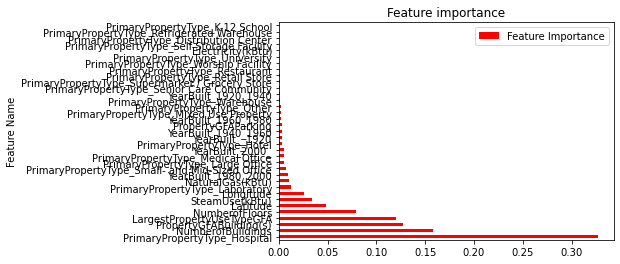

In [123]:
def display_feat_imp_xgboost(boosted):
  feat_imp = model_boosted.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = X_train.columns
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(model_boosted)

In [93]:
scores.append(model_boosted.score(X_test,y1_test))
best_scores.append(CV_xgboost.best_score_)

In [94]:
res_xgboost = pd.DataFrame(CV_xgboost.cv_results_)

In [95]:
index = ['Dummy','Random Forest','Ridge','KNN','XGBoost']
columns = ['test score']
columns_b = ['validation score']

In [96]:
df_scores = pd.DataFrame(data=scores,index=index,columns=columns)
df_best_scores = pd.DataFrame(data=best_scores,index=index,columns=columns_b)

In [97]:
df_scores

,test score
Dummy,-0.000272
Random Forest,0.780988
Ridge,0.749471
KNN,0.318475
XGBoost,0.863427


In [98]:
df_best_scores

,validation score
Dummy,-0.003790
Random Forest,0.607477
Ridge,0.475321
KNN,0.265141
XGBoost,0.616449


### Energy Star Score

In [99]:
energyStar = nonRes[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','ENERGYSTARScore']]

In [100]:
energyStar = energyStar.dropna(axis=0)

In [101]:
energyStar.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    0
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
ENERGYSTARScore              0
dtype: int64

In [102]:
energyStar['YearBuilt'] = energyStar['YearBuilt'].apply(fill_date)

In [103]:
energyStar['SteamUse(kBtu)'] = energyStar['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
energyStar['Electricity(kBtu)'] = energyStar['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
energyStar['NaturalGas(kBtu)'] = energyStar['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [104]:
energyStar_code = pd.get_dummies(energyStar ,columns=['PrimaryPropertyType','YearBuilt'])

In [105]:
train_EStar, test_EStar = train_test_split(energyStar_code, test_size=0.3, random_state=0) 

In [106]:
Xe_train, ye_train, Xe_test, ye_test = train_EStar.drop(columns = ['TotalGHGEmissions']), train_EStar['TotalGHGEmissions'],test_EStar.drop(columns = ['TotalGHGEmissions']) ,test_EStar['TotalGHGEmissions']

In [126]:
#CV_xgboost_Estar = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
#CV_xgboost_Estar.fit(Xe_train, ye_train)

In [138]:
rfr_eStar = GradientBoostingRegressor( **CV_xgboost.best_params_)

In [139]:
rfr_eStar.fit(Xe_train, ye_train)

GradientBoostingRegressor(max_depth=4, max_features='sqrt', random_state=12)

In [140]:
rfr_eStar.score(Xe_test,ye_test)

0.7003878891285115

    Feature Importance                                     Feature Name
12        2.789012e-01                     PrimaryPropertyType_Hospital
4         2.271981e-01                           PropertyGFABuilding(s)
6         2.080987e-01                        LargestPropertyUseTypeGFA
2         8.098597e-02                                NumberofBuildings
7         4.842098e-02                                   SteamUse(kBtu)
3         4.237018e-02                                   NumberofFloors
10        3.364057e-02                                  ENERGYSTARScore
0         2.109431e-02                                         Latitude
29        2.035025e-02                              YearBuilt_1980_2000
1         9.989474e-03                                        Longitude
9         5.912751e-03                                 NaturalGas(kBtu)
13        5.786598e-03                        PrimaryPropertyType_Hotel
18        3.138143e-03                        PrimaryPropertyTyp

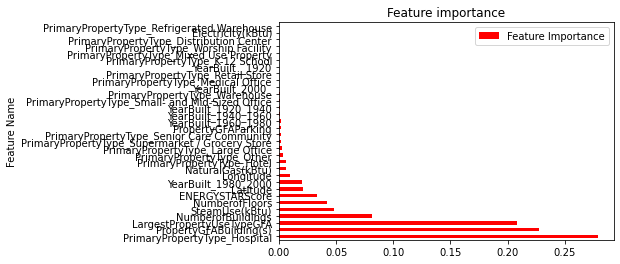

In [141]:
def display_feat_imp_xgboost(boosted):
  feat_imp = rfr_eStar.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = Xe_train.columns
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(rfr_eStar)

In [111]:
Xee_train, yee_train, Xee_test, yee_test = train_EStar.drop(columns = ['TotalGHGEmissions','ENERGYSTARScore']), train_EStar['TotalGHGEmissions'],test_EStar.drop(columns = ['TotalGHGEmissions','ENERGYSTARScore']) ,test_EStar['TotalGHGEmissions']

In [137]:
#CV_xgboost_EEstar = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
#CV_xgboost_EEstar.fit(Xee_train, yee_train)

In [142]:
rfr_eStar.fit(Xee_train,yee_train)

GradientBoostingRegressor(max_depth=4, max_features='sqrt', random_state=12)

In [143]:
rfr_eStar.score(Xee_test,yee_test)

0.5820535863427334

### <a name='C2'> Prédictions de SiteEnergyUse(kbtu)   </a>

### - Dummy Regressor

In [163]:
CV_dummy_en = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_dummy_en.fit(X_train, y2_train)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [159]:
CV_dummy_en.best_score_

-0.004232080647240721

In [160]:
print(f"Score - training data: {round(CV_dummy_en.score(X_train,y2_train)*100,2)} %")
print(f"Score - test data: {round(CV_dummy_en.score(X_test,y2_test)*100,2)} %")

Score - training data: 0.0 %
Score - test data: -0.05 %


### - Random Forest

In [155]:
CV_rfr_en = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfc_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_rfr_en.fit(X_train, y2_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 8, 16, 32, 64],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error'])

In [156]:
CV_rfr_en.best_score_

0.6415500688335675

In [157]:
print(f"Score - training data: {round(CV_rfr_en.score(X_train,y2_train)*100,2)} %")
print(f"Score - test data: {round(CV_rfr_en.score(X_test,y2_test)*100,2)} %")

Score - training data: 93.82 %
Score - test data: 76.44 %


### - Ridge Regressor

In [154]:
CV_ridge_en = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 6,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_ridge_en.fit(X_train, y2_train)

GridSearchCV(cv=6, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10]}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [161]:
CV_ridge_en.best_score_

0.587046098307877

In [162]:
print(f"Score - training data: {round(CV_ridge_en.score(X_train,y2_train)*100,2)} %")
print(f"Score - test data: {round(CV_ridge_en.score(X_test,y2_test)*100,2)} %")

Score - training data: 65.65 %
Score - test data: 77.57 %


### - KNN Regressor

In [164]:
CV_knn_en = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_param_grid, cv= 6,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_knn_en.fit(X_train, y2_train)

GridSearchCV(cv=6, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [165]:
CV_knn_en.best_score_

0.45639760724407524

In [166]:
print(f"Score - training data: {round(CV_knn_en.score(X_train,y2_train)*100,1)} %")
print(f"Score - test data: {round(CV_knn_en.score(X_test,y2_test)*100,1)} %")

Score - training data: 45.5 %
Score - test data: 50.0 %


### - XGBoost

In [167]:
CV_xgboost_en = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost_en.fit(X_train, y2_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 8, 16, 32, 64],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [168]:
CV_xgboost_en.best_score_

0.6412370567388679

In [173]:
CV_xgboost_en.cv_results_

{'mean_fit_time': array([0.19885502, 0.40000105, 0.60337219, 0.81783872, 0.97452526,
        0.05336986, 0.10668206, 0.15393138, 0.20610719, 0.2636899 ,
        0.05275455, 0.11032085, 0.15904613, 0.20426331, 0.26663671,
        0.36943932, 0.7331367 , 1.13253579, 1.43941975, 1.92149224,
        0.0870059 , 0.19125934, 0.28202748, 0.38332911, 0.4131453 ,
        0.09280605, 0.19961066, 0.25110173, 0.34834847, 0.46812377,
        0.61890264, 1.24858789, 1.79568639, 2.35790553, 2.969315  ,
        0.14005876, 0.27868366, 0.43506198, 0.57677774, 0.73196673,
        0.14047961, 0.28314209, 0.42334566, 0.56726785, 0.70273061,
        0.70970268, 1.42321773, 2.12031446, 2.30811706, 2.40046873,
        0.18105831, 0.36273556, 0.54414921, 0.60195508, 0.63958421,
        0.18058686, 0.36334176, 0.53909388, 0.59768815, 0.63970919,
        0.70738807, 1.41465116, 2.11713309, 2.30773044, 2.39159408,
        0.18294702, 0.36254888, 0.53886232, 0.59887724, 0.6356565 ,
        0.18478971, 0.36015005,

In [169]:
print(f"Score - training data: {round(CV_xgboost_en.score(X_train,y2_train)*100,1)} %")
print(f"Score - test data: {round(CV_xgboost_en.score(X_test,y2_test)*100,1)} %")

Score - training data: 99.3 %
Score - test data: 83.2 %
